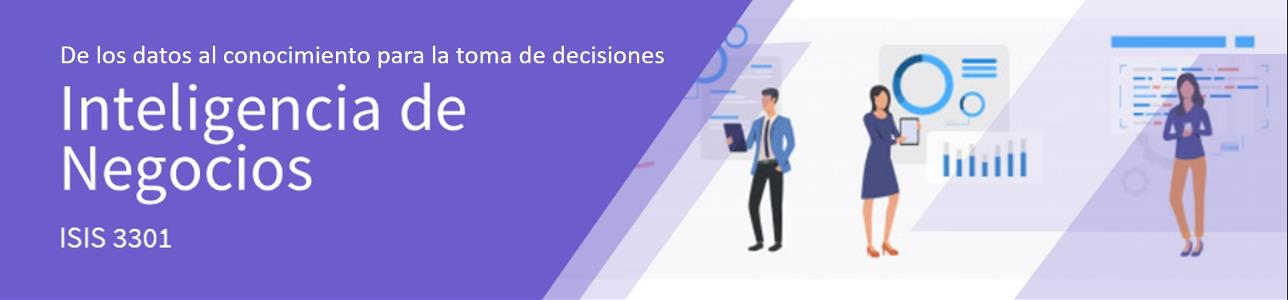

# Proyecto 1 - Analítica de Textos
### Andrés Sánchez (201821941), Daniel Rincón (201822574), Jhorman Caballero (201812920)

## 0. Manejo de librerías y lectura de los datos.


In [170]:
                # Librería para manejar las contracciones que se presentan en el inglés.

# Requiere Microsoft Visual C++ 14.0
!pip install contractions
!pip install textsearch

In [171]:
!pip install neattext
!pip install textblob
!pip install wordcloud
!pip install eli5
!pip install lime

In [172]:
# librería para manejar las flexiones gramaticales en el idioma inglés.
!pip install inflect
!pip install pandas-profiling==2.7.1

In [173]:
# librería Natural Language Toolkit, usada para trabajar con textos 
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jhorm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [174]:
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jhorm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [175]:
# Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jhorm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [176]:
# Importación de librerias
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve
from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt
import seaborn as sns
import neattext.functions as nfx
from textblob import TextBlob
from collections import Counter

# Interpretación del modelo
import eli5
import lime
from lime import lime_tabular

## 1. Perfilamiento y entendimiento de los datos



#### Lectura de los datos.

In [177]:
# Uso de la libreria pandas para la lectura de archivos
data=pd.read_csv('train.txt', sep=';', encoding = 'utf-8')
# Asignación a una nueva variable de los datos leidos
data_t=data

In [178]:
data.shape

(16000, 2)

In [179]:
data.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [180]:
data.dtypes

Text       object
Emotion    object
dtype: object

In [181]:
data['Emotion'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

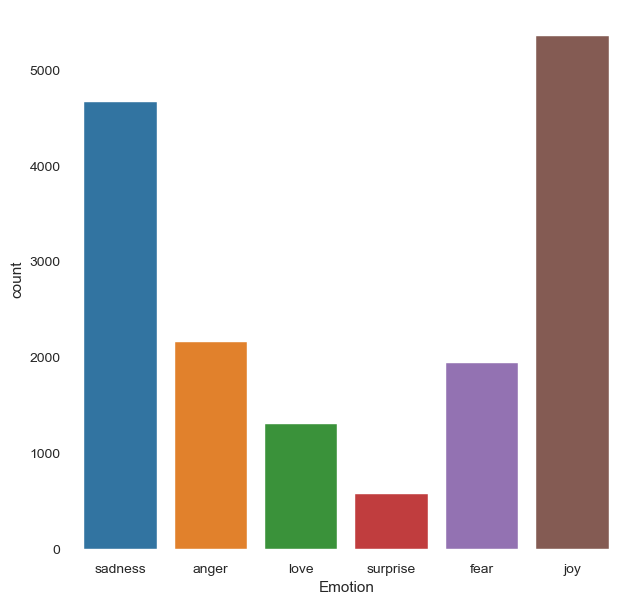

In [182]:
plt.figure(figsize=(7,7))
sns.countplot(x='Emotion',data=data)
plt.show()

Como se puede ver, la información es no balanceada. Hay categorías de la variable emoción que no tienen muchos datos en comparación a otras. Por ejemplo, surprise aparece muy poco, en cambio joy es la emoción que más aparece.

### Exploración
+ Text Cleaning
+ Sentiment Analysis
+ Keyword Extraction
    - Keywords for each emotion
    - Wordcloud

#### Sentiment Analysis

In [183]:
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        result = 'Positivo'
    elif sentiment < 0:
        result = 'Negativo'
    else:
        result = 'Neutral'
    return result

In [184]:
# Prueba de función
get_sentiment("I hate Mondays")

'Negativo'

In [185]:
data['Sentimiento'] = data['Text'].apply(get_sentiment)

In [186]:
data['Sentimiento'].value_counts()

Positivo    7634
Negativo    5189
Neutral     3177
Name: Sentimiento, dtype: int64

In [187]:
# Comparación de Emotion con Sentimiento
data.groupby(['Emotion','Sentimiento']).size()

Emotion   Sentimiento
anger     Negativo       1047
          Neutral         545
          Positivo        567
fear      Negativo        871
          Neutral         452
          Positivo        614
joy       Negativo        589
          Neutral         776
          Positivo       3997
love      Negativo        244
          Neutral         179
          Positivo        881
sadness   Negativo       2205
          Neutral        1165
          Positivo       1296
surprise  Negativo        233
          Neutral          60
          Positivo        279
dtype: int64

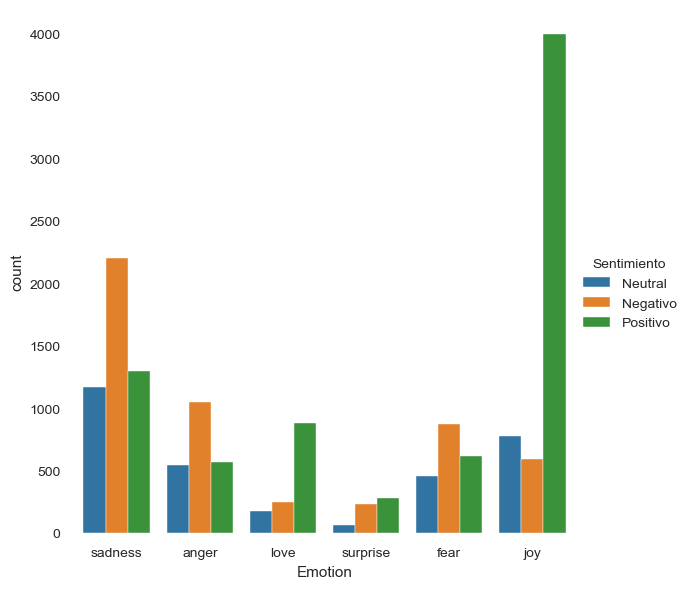

In [188]:
sns.catplot(x='Emotion', hue='Sentimiento', data=data, height=6, kind='count')
plt.show()
#sns.catplot

#### Text Cleaning
+ Remove noise
    - Stopwords
    - Special characters
    - Punctuations

In [189]:
data['Clean_Text']=data['Text'].apply(nfx.remove_stopwords)

In [190]:
data['Clean_Text']=data['Clean_Text'].apply(nfx.remove_userhandles)

In [191]:
data['Clean_Text']=data['Clean_Text'].apply(nfx.remove_punctuations)

In [192]:
data[['Text','Clean_Text']]

,Text,Clean_Text
0,i didnt feel humiliated,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,feeling hopeless damned hopeful cares awake
2,im grabbing a minute to post i feel greedy wrong,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,feeling nostalgic fireplace know property
4,i am feeling grouchy,feeling grouchy
...,...,...
15995,i just had a very brief time in the beanbag an...,brief time beanbag said anna feel like beaten
15996,i am now turning and i feel pathetic that i am...,turning feel pathetic waiting tables subbing t...
15997,i feel strong and good overall,feel strong good overall
15998,i feel like this was such a rude comment and i...,feel like rude comment im glad


#### Keyword Extraction
+ Extract most common words per class of emotion

In [193]:
def extract_keywords(text,num=10):
    tokens = [ tok for tok in text.split()]
    most_common_tokens = Counter(tokens).most_common(num)
    return dict(most_common_tokens)

In [194]:
# list of emotions
emotions_list = data['Emotion'].unique().tolist()
emotions_list

['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']

In [195]:
# Se puede hacer para cada emoción
joy_list = data[data['Emotion'] == 'joy']['Clean_Text'].tolist()

In [196]:
joy_docx = ' '.join(joy_list)

In [197]:
# Extract Keywords
keywords_joy = extract_keywords(joy_docx)

In [198]:
# Top 50 keywords of joy
keywords_joy

{'feel': 3928,
 'feeling': 1539,
 'like': 1006,
 'im': 799,
 'time': 290,
 'know': 240,
 'want': 203,
 'people': 203,
 'think': 198,
 'good': 196}

In [199]:
# Plot
def plot_most_common_words(mydict,emotion_name):
    df_plot = pd.DataFrame(mydict.items(),columns=['token','count'])
    plt.figure(figsize=(15,10))
    plt.title("Plot of {} Most Common Keywords".format(emotion_name))
    sns.barplot(x='token',y='count',data=df_plot)
    plt.xticks(rotation=45)
    plt.savefig("PlotOf{}".format(emotion_name))
    plt.show()

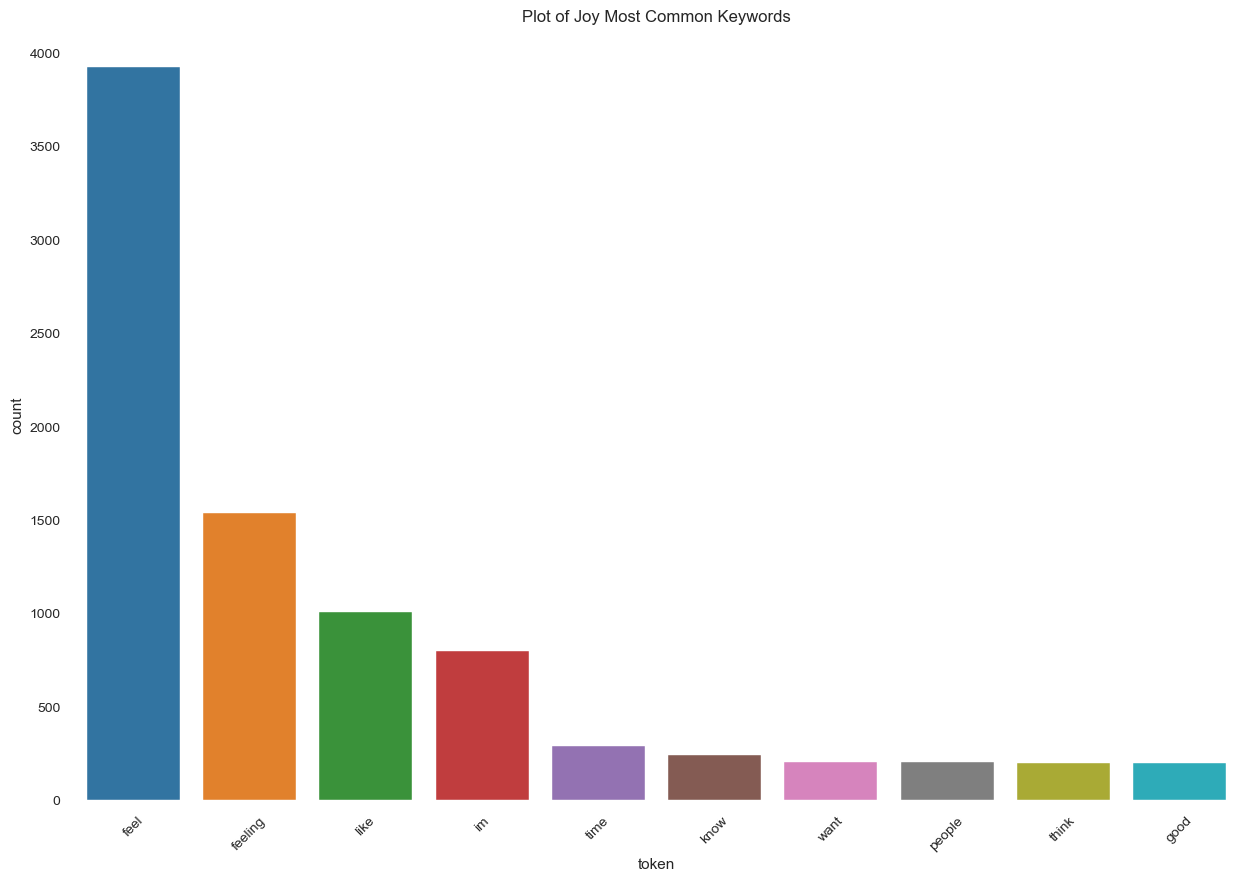

In [200]:
plot_most_common_words(keywords_joy,"Joy")

In [201]:
anger_list = data[data['Emotion'] == 'anger']['Clean_Text'].tolist()
# Document
anger_docx = ' '.join(anger_list)
#Extract Keywords
keywords_anger = extract_keywords(anger_docx)

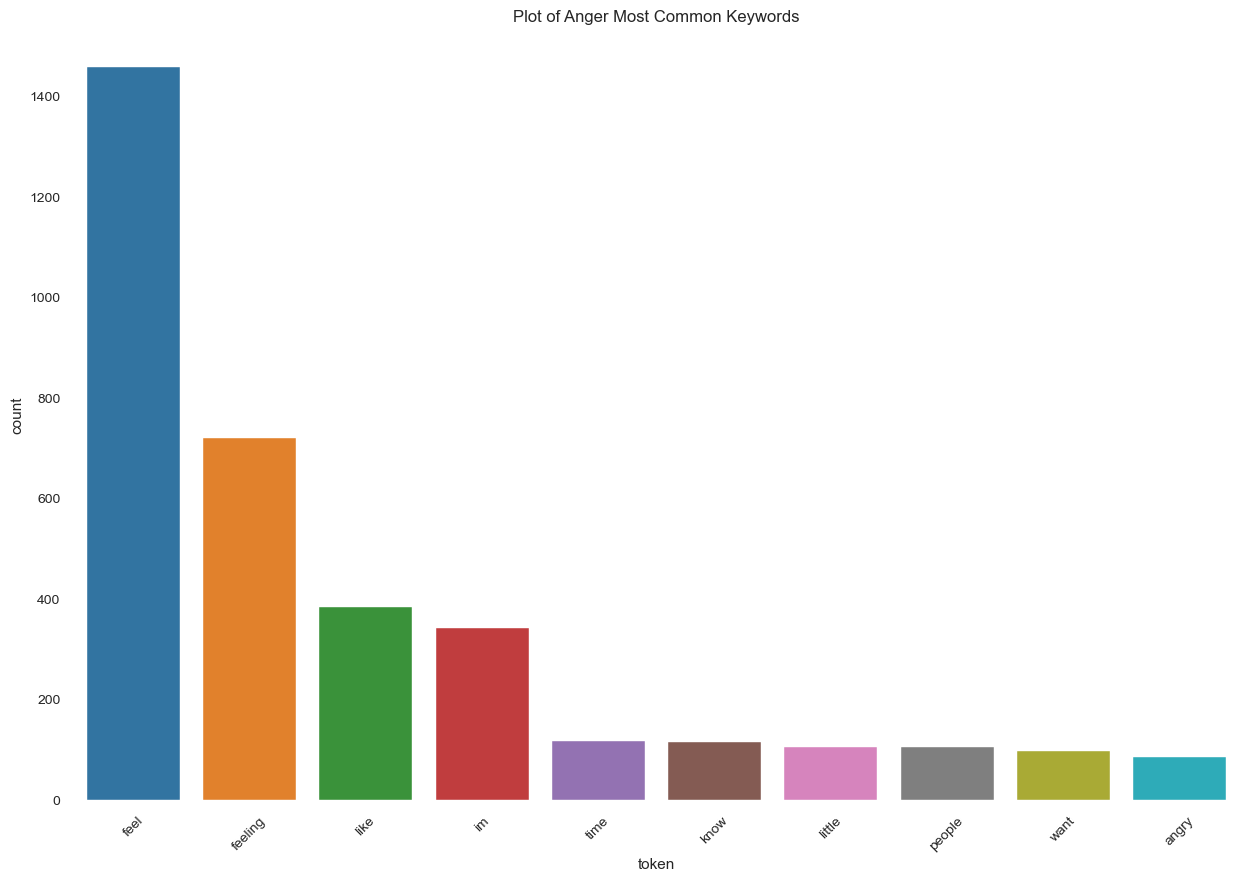

In [202]:
plot_most_common_words(keywords_anger,"Anger")

In [203]:
# Importar Word Cloud
from wordcloud import WordCloud

In [204]:
# Creación de una gráfica alternativa para visualizar la frecuencia de las palabras.
def plot_wordcloud(docx):
    wc = WordCloud().generate(docx)
    plt.figure(figsize=(20,10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

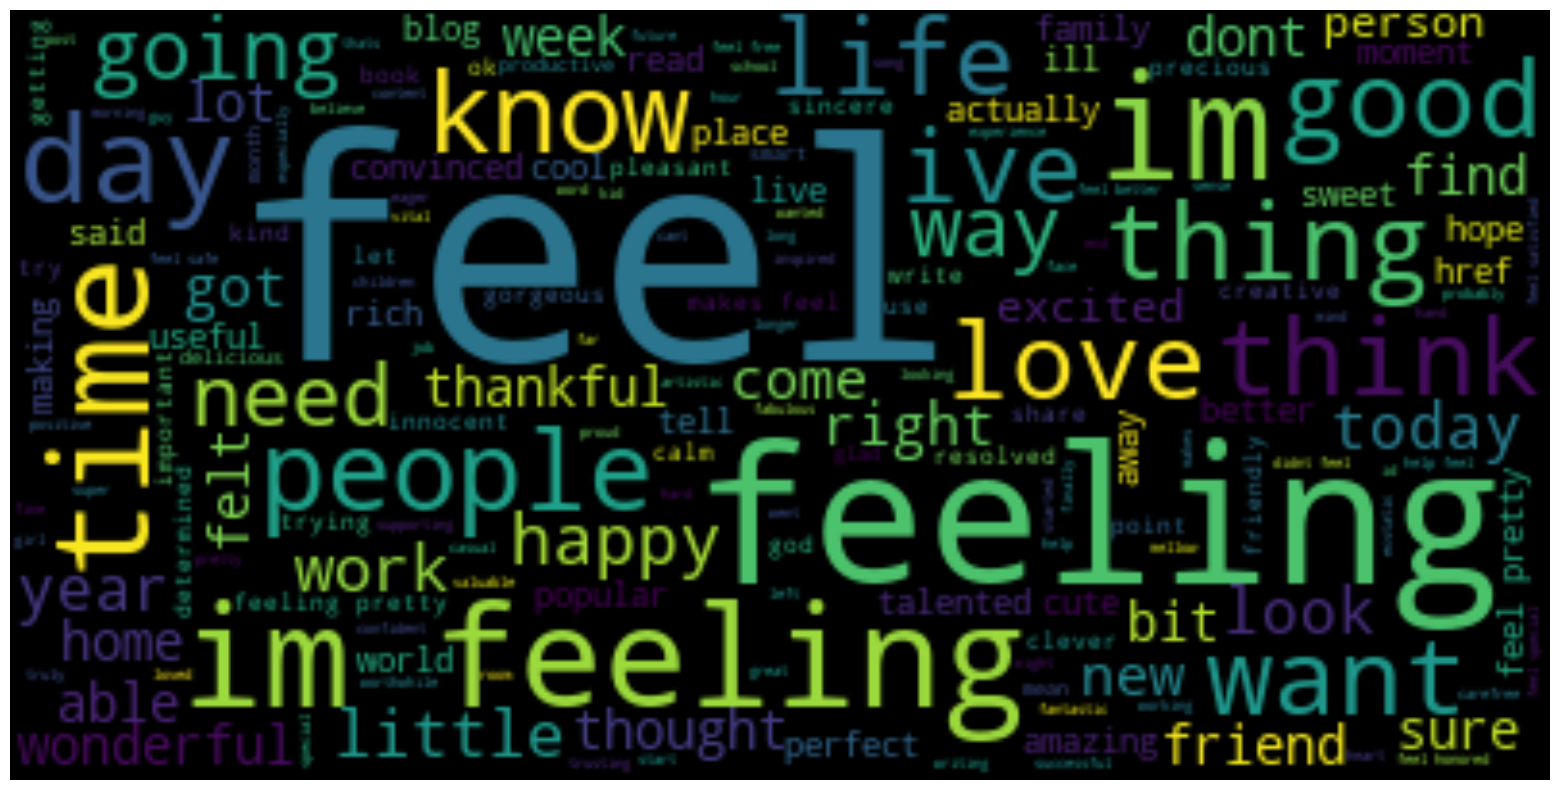

In [205]:
# Muestra de palabras relacionadas a joy con una nube de palabras.
plot_wordcloud(joy_docx)

In [206]:
# Muestra de palabras relacionadas a joy con una nube de palabras.
plot_wordcloud(surprise_docx)

NameError: name 'surprise_docx' is not defined

Entendiendo la distribución básica de las emociones y algunas de las palabras a las que son asociadas frecuentemente, se puede proseguir a crear y entrenar distintos modelos en búsqueda de la solución óptima.

## 2. Modelaje

### MultinomialNB (Andrés Felipe Sánchez - 201821941)

In [207]:
# Importar modelo
from sklearn.naive_bayes import MultinomialNB
# Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Importar presentación de métricas
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, plot_confusion_matrix
# Importar división de datos en secciones de entrenamiento y de prueba.
from sklearn.model_selection import train_test_split

In [208]:
# Features a analizar
Xfeatures = data['Clean_Text']
# Variable objetivo
ylabels = data['Emotion']
Xfeatures

0                                    didnt feel humiliated
1              feeling hopeless damned hopeful cares awake
2                im grabbing minute post feel greedy wrong
3                feeling nostalgic fireplace know property
4                                          feeling grouchy
                               ...                        
15995        brief time beanbag said anna feel like beaten
15996    turning feel pathetic waiting tables subbing t...
15997                             feel strong good overall
15998                       feel like rude comment im glad
15999                         know lot feel stupid portray
Name: Clean_Text, Length: 16000, dtype: object

In [209]:
# Convertir la lista de features en un vector.
cv = CountVectorizer()
X = cv.fit_transform(Xfeatures)

In [210]:
cv.get_feature_names()

['aa',
 'aaaaaaand',
 'aaaaand',
 'aaaand',
 'aac',
 'aahhh',
 'aaron',
 'ab',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abated',
 'abbigail',
 'abc',
 'abdomen',
 'abdominal',
 'abducted',
 'abelard',
 'abhorrent',
 'abide',
 'abilities',
 'ability',
 'abit',
 'able',
 'ableness',
 'abnormally',
 'aboard',
 'abominable',
 'abortion',
 'abou',
 'abound',
 'abraham',
 'abroad',
 'abruptly',
 'absence',
 'absolute',
 'absolutely',
 'absolutly',
 'absorbed',
 'abstain',
 'abstinence',
 'abstract',
 'absurd',
 'absurdity',
 'abt',
 'abundance',
 'abundantly',
 'abuse',
 'abused',
 'abuses',
 'abusing',
 'abusive',
 'abyss',
 'ac',
 'academia',
 'academic',
 'academics',
 'academy',
 'acause',
 'accelerated',
 'accent',
 'accentuating',
 'accept',
 'acceptable',
 'acceptance',
 'acceptances',
 'accepted',
 'accepting',
 'accepts',
 'access',
 'accessaries',
 'accessibility',
 'accessories',
 'accessory',
 'accident',
 'accidentally',
 'accidents',
 'acclimated',
 'acco',
 '

In [211]:
# Partición de los datos
X_train,X_test,y_train,y_test = train_test_split(X,ylabels,test_size=0.3,random_state=42)


In [212]:
nv_model = MultinomialNB()
nv_model.fit(X_train,y_train)

MultinomialNB()

In [213]:
# Métrica de exactitud promedio
nv_model.score(X_test,y_test)

0.769375

In [214]:
# Predicción con conjunto de datos de prueba
y_pred_for_nv = nv_model.predict(X_test)
y_pred_for_nv

array(['sadness', 'joy', 'sadness', ..., 'fear', 'joy', 'fear'],
      dtype='<U8')

In [215]:
# Métricas de clasificación
print(classification_report(y_test,y_pred_for_nv))

              precision    recall  f1-score   support

       anger       0.85      0.63      0.72       607
        fear       0.84      0.60      0.70       566
         joy       0.73      0.95      0.83      1581
        love       0.86      0.29      0.43       434
     sadness       0.76      0.93      0.84      1434
    surprise       0.89      0.10      0.17       178

    accuracy                           0.77      4800
   macro avg       0.82      0.58      0.62      4800
weighted avg       0.79      0.77      0.74      4800



Dado que estas métricas son las aplicadas a modelos de clasificación, se puede saber inmediatamente que la exactitud del modelo señala con qué frecuencia es correcto el clasificador de manera general, que la precisión de cada clase apunta al porcentaje de asignaciones a esa clase que fueron correctas, que el recall representa cuántas de los valores reales predijo correctamente el modelo, y que el puntaje F1 es la media armónica entre la precisión y el recall.

In [216]:
# Matriz de confusión
#confusion_matrix(y_test,y_pred_for_nv)
plot_confusion_matrix(nv_model,X_test,y_test)

### Regresión Logística (Daniel Rincón G. – 201822574)

In [217]:
# Importar modelos
from sklearn.linear_model import LogisticRegression
# Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Importar presentación de métricas
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, plot_confusion_matrix
# Importar división de datos en secciones de entrenamiento y de prueba.
from sklearn.model_selection import train_test_split

In [218]:
# Features a analizar
Xfeatures = data['Clean_Text']
# Variable objetivo
ylabels = data['Emotion']
Xfeatures

0                                    didnt feel humiliated
1              feeling hopeless damned hopeful cares awake
2                im grabbing minute post feel greedy wrong
3                feeling nostalgic fireplace know property
4                                          feeling grouchy
                               ...                        
15995        brief time beanbag said anna feel like beaten
15996    turning feel pathetic waiting tables subbing t...
15997                             feel strong good overall
15998                       feel like rude comment im glad
15999                         know lot feel stupid portray
Name: Clean_Text, Length: 16000, dtype: object

In [219]:
# Convertir la lista de features en un vector.
cv = CountVectorizer()
X = cv.fit_transform(Xfeatures)

In [220]:
cv.get_feature_names()

['aa',
 'aaaaaaand',
 'aaaaand',
 'aaaand',
 'aac',
 'aahhh',
 'aaron',
 'ab',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abated',
 'abbigail',
 'abc',
 'abdomen',
 'abdominal',
 'abducted',
 'abelard',
 'abhorrent',
 'abide',
 'abilities',
 'ability',
 'abit',
 'able',
 'ableness',
 'abnormally',
 'aboard',
 'abominable',
 'abortion',
 'abou',
 'abound',
 'abraham',
 'abroad',
 'abruptly',
 'absence',
 'absolute',
 'absolutely',
 'absolutly',
 'absorbed',
 'abstain',
 'abstinence',
 'abstract',
 'absurd',
 'absurdity',
 'abt',
 'abundance',
 'abundantly',
 'abuse',
 'abused',
 'abuses',
 'abusing',
 'abusive',
 'abyss',
 'ac',
 'academia',
 'academic',
 'academics',
 'academy',
 'acause',
 'accelerated',
 'accent',
 'accentuating',
 'accept',
 'acceptable',
 'acceptance',
 'acceptances',
 'accepted',
 'accepting',
 'accepts',
 'access',
 'accessaries',
 'accessibility',
 'accessories',
 'accessory',
 'accident',
 'accidentally',
 'accidents',
 'acclimated',
 'acco',
 '

In [221]:
# Partición de los datos
X_train,X_test,y_train,y_test = train_test_split(X,ylabels,test_size=0.3,random_state=42)

In [222]:
# Creación del modelo
lr_model = LogisticRegression()
# Modelo alcanza número máximo de iteraciones pero genera un resultado adecuado.
lr_model.fit(X_train,y_train)

LogisticRegression()

In [223]:
# Métrica de exactitud promedio
lr_model.score(X_test,y_test)

0.8866666666666667

In [224]:
# Predicción con conjunto de datos de prueba
y_pred_for_nv = lr_model.predict(X_test)
y_pred_for_nv

array(['sadness', 'joy', 'sadness', ..., 'fear', 'joy', 'fear'],
      dtype=object)

In [225]:
# Métricas de clasificación
print(classification_report(y_test,y_pred_for_nv))

              precision    recall  f1-score   support

       anger       0.88      0.86      0.87       607
        fear       0.87      0.83      0.85       566
         joy       0.87      0.95      0.91      1581
        love       0.85      0.74      0.79       434
     sadness       0.92      0.92      0.92      1434
    surprise       0.85      0.71      0.78       178

    accuracy                           0.89      4800
   macro avg       0.88      0.83      0.85      4800
weighted avg       0.89      0.89      0.89      4800



In [226]:
# Matriz de confusión
#confusion_matrix(y_test,y_pred_for_nv)
plot_confusion_matrix(lr_model,X_test,y_test)

In [227]:
# Peso de los features de cada categoría
class_names = ylabels.unique().tolist()
feature_names = cv.get_feature_names()
eli5.show_weights(lr_model, feature_names=feature_names, target_names=class_names, top=20)

### SGD Classifier (Jhorman Caballero - 201812920)

In [228]:
# Instalaciones necesarias
!pip install parfit

In [229]:
#Librerias necesarias
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf

In [230]:
# Features a analizar
Xfeatures = data['Clean_Text']
# Variable objetivo
ylabels = data['Emotion']
Xfeatures

0                                    didnt feel humiliated
1              feeling hopeless damned hopeful cares awake
2                im grabbing minute post feel greedy wrong
3                feeling nostalgic fireplace know property
4                                          feeling grouchy
                               ...                        
15995        brief time beanbag said anna feel like beaten
15996    turning feel pathetic waiting tables subbing t...
15997                             feel strong good overall
15998                       feel like rude comment im glad
15999                         know lot feel stupid portray
Name: Clean_Text, Length: 16000, dtype: object

In [231]:
# Convertir la lista de features en un vector.
cv = CountVectorizer()
X = cv.fit_transform(Xfeatures)

In [232]:
xtrain, xtest, ytrain, ytest = train_test_split(X, ylabels, test_size = 0.3)

sgdc = SGDClassifier(max_iter=1000, tol=0.01)
 
sgdc.fit(xtrain, ytrain)

SGDClassifier(tol=0.01)

In [233]:
score = sgdc.score(xtrain, ytrain)
print("Training score: ", score)

Training score:  0.9855357142857143


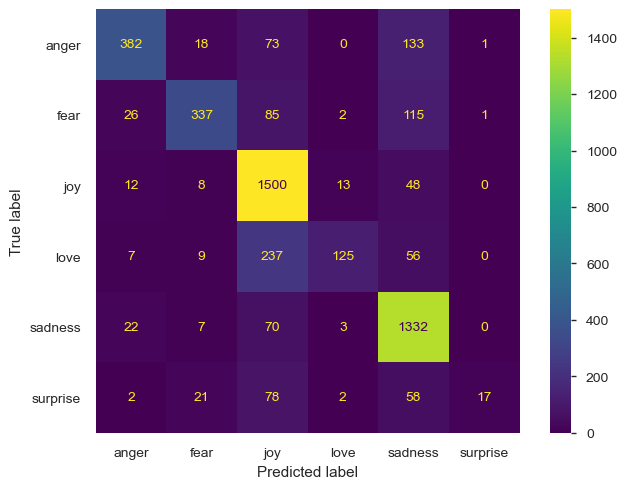

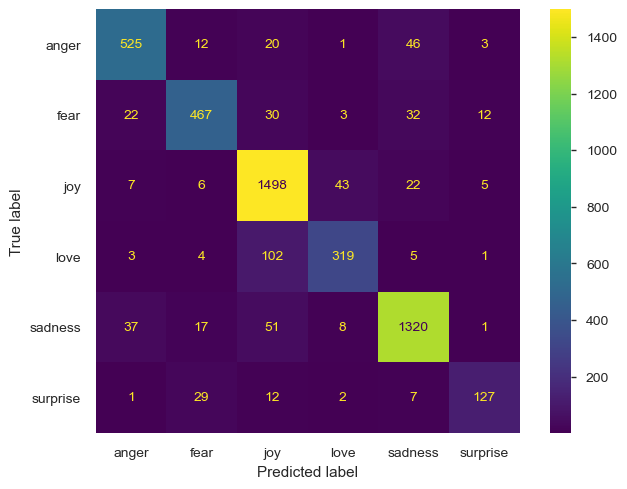

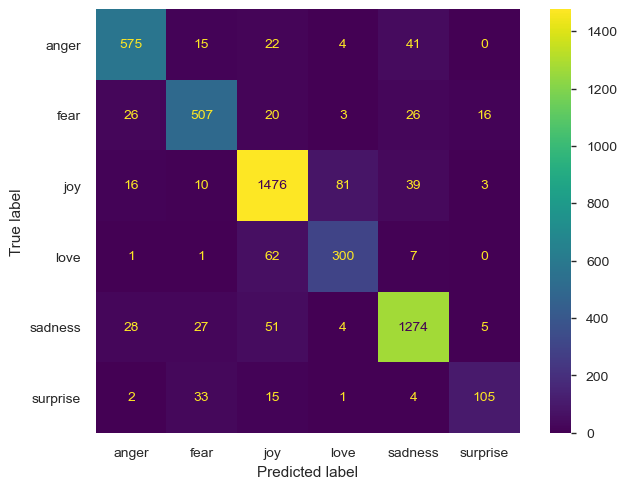

In [234]:
ypred = sgdc.predict(xtest)

plot_confusion_matrix(sgdc,xtest,ytest)
plt.show()

In [235]:
cr = classification_report(ytest, ypred)
print(cr)

              precision    recall  f1-score   support

       anger       0.89      0.88      0.88       657
        fear       0.85      0.85      0.85       598
         joy       0.90      0.91      0.90      1625
        love       0.76      0.81      0.79       371
     sadness       0.92      0.92      0.92      1389
    surprise       0.81      0.66      0.73       160

    accuracy                           0.88      4800
   macro avg       0.86      0.84      0.84      4800
weighted avg       0.88      0.88      0.88      4800

